In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = conv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.ca = ChannelAttention(32)
        self.sa = SpatialAttention()
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv = nn.Conv2d(32, 3, 3, stride = 1)
        self.flatten = nn.Flatten()     
        self.sigmoid = nn.Sigmoid()
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.ca(x) * x
        x = self.sa(x) * x
        
        #全結合層
        x = self.flatten(self.global_avg(self.sigmoid(self.conv(x))))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─conv2DBatchNormRelu: 1-3               [64, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 32, 16, 16]          4,640
│    └─BatchNorm2d: 2-6                  [64, 32, 16, 16]          64
│    └─ReLU: 2-7                         [64, 32, 16, 16]          --
│    └─Dropout2d: 2-8                    [64, 32, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 32, 8, 8]            --
├─ChannelAt

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 1.0987 Acc: 0.3333
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 1.0558 Acc: 0.4625


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.50it/s]


val Loss: 1.0820 Acc: 0.3819
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.9876 Acc: 0.5405


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.53it/s]


val Loss: 1.0032 Acc: 0.4957
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.9556 Acc: 0.5886


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.57it/s]


val Loss: 0.9512 Acc: 0.5743
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.9384 Acc: 0.5966


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.48it/s]


val Loss: 0.8854 Acc: 0.6595
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.06s/it]


train Loss: 0.9281 Acc: 0.6156


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.47it/s]


val Loss: 0.9247 Acc: 0.5871
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.9207 Acc: 0.6236


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.53it/s]


val Loss: 0.9001 Acc: 0.6181
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.9128 Acc: 0.6336


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.53it/s]


val Loss: 0.8995 Acc: 0.6071
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.9054 Acc: 0.6476


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.58it/s]


val Loss: 0.8472 Acc: 0.6824
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8973 Acc: 0.6587


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.8559 Acc: 0.7143
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8961 Acc: 0.6446


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.52it/s]


val Loss: 0.8476 Acc: 0.7181
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.8875 Acc: 0.6486


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.53it/s]


val Loss: 0.8635 Acc: 0.7024
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8893 Acc: 0.6617


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.49it/s]


val Loss: 0.9109 Acc: 0.6395
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8818 Acc: 0.6607


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.55it/s]


val Loss: 0.8259 Acc: 0.7352
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8816 Acc: 0.6687


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.58it/s]


val Loss: 0.8338 Acc: 0.7205
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8687 Acc: 0.6727


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.57it/s]


val Loss: 0.8361 Acc: 0.7162
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8809 Acc: 0.6446


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.53it/s]


val Loss: 0.8379 Acc: 0.7186
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.8692 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8081 Acc: 0.7510
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8621 Acc: 0.6857


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.55it/s]


val Loss: 0.8789 Acc: 0.6486
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8734 Acc: 0.6647


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8060 Acc: 0.7538
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8713 Acc: 0.6797


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8111 Acc: 0.7424
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.8521 Acc: 0.6997


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.7887 Acc: 0.7838
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.8577 Acc: 0.6857


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.58it/s]


val Loss: 0.8846 Acc: 0.6700
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8627 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8721 Acc: 0.6319
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8473 Acc: 0.7077


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8289 Acc: 0.7267
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.8372 Acc: 0.7147


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8659 Acc: 0.6500
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.8574 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.57it/s]


val Loss: 0.8547 Acc: 0.6529
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.8452 Acc: 0.6967


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.55it/s]


val Loss: 0.8153 Acc: 0.7510
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.8420 Acc: 0.7187


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.60it/s]


val Loss: 0.7819 Acc: 0.7752
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.8443 Acc: 0.7107


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.57it/s]


val Loss: 0.7860 Acc: 0.7810
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8408 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.7717 Acc: 0.7871
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8281 Acc: 0.7277


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.58it/s]


val Loss: 0.7768 Acc: 0.7890
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8409 Acc: 0.7077


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.60it/s]


val Loss: 0.7769 Acc: 0.7971
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8368 Acc: 0.6997


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.46it/s]


val Loss: 0.7784 Acc: 0.7833
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8313 Acc: 0.7147


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.7752 Acc: 0.7810
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8287 Acc: 0.7117


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.53it/s]


val Loss: 0.8300 Acc: 0.7257
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8314 Acc: 0.7237


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.8553 Acc: 0.6967
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.8163 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.58it/s]


val Loss: 0.7716 Acc: 0.7843
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.06s/it]


train Loss: 0.8137 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.51it/s]


val Loss: 0.8485 Acc: 0.6738
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8361 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.7536 Acc: 0.8105
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8113 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.55it/s]


val Loss: 0.7795 Acc: 0.7710
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8224 Acc: 0.7277


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.57it/s]


val Loss: 0.7959 Acc: 0.7424
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8220 Acc: 0.7347


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.57it/s]


val Loss: 0.7840 Acc: 0.7781
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.8214 Acc: 0.7317


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8034 Acc: 0.7533
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8204 Acc: 0.7297


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.7741 Acc: 0.7805
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8040 Acc: 0.7528


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.57it/s]


val Loss: 0.7709 Acc: 0.7914
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8142 Acc: 0.7397


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.7990 Acc: 0.7452
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8081 Acc: 0.7367


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.59it/s]


val Loss: 0.8216 Acc: 0.7257
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8239 Acc: 0.7187


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.53it/s]


val Loss: 0.7996 Acc: 0.7490
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8180 Acc: 0.7267


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.52it/s]

val Loss: 0.7781 Acc: 0.7681


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

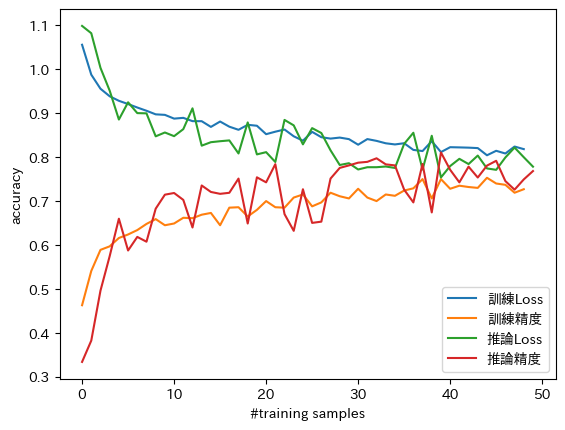

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

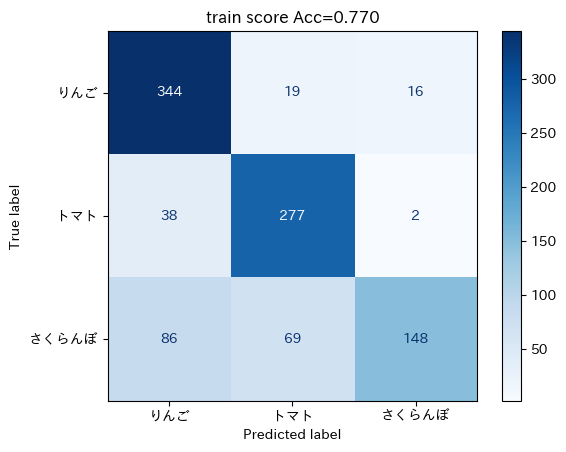

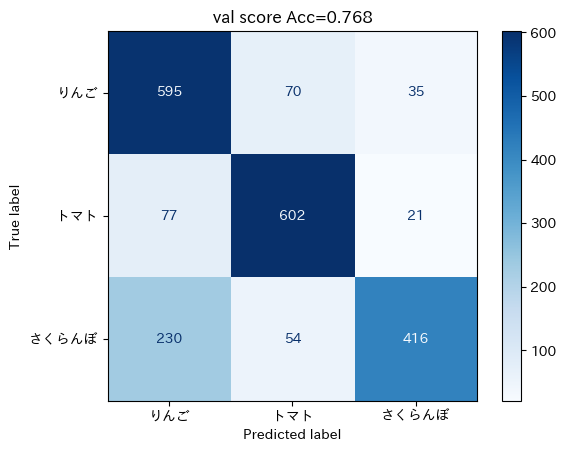

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

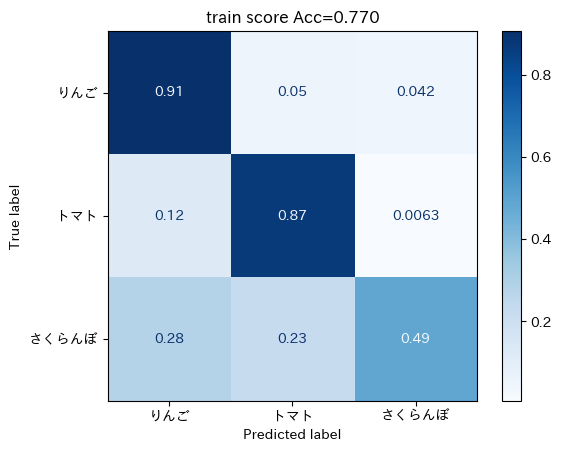

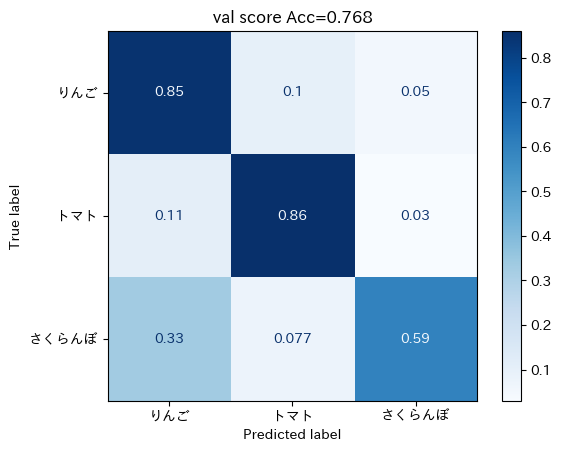

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()